# Preprocessing:
### Remove 50Hz signal and slow drift resulting from measurement process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import signal
from scipy.signal import lfilter, butter
from scipy import linalg




In [2]:
#Read data and annotations
DF = pd.read_csv("Data/100.csv", dtype=int, sep='\s*,\s*',delimiter=',')
DF_annotations = pd.read_csv("Data/104annotations.txt", header=0, sep=r"\s+")

#Extra column "DummyCol" (contains only NaN) is present to deal with column names in original file that contain a white space
DF_annotations.columns = ["Time", "Sample #", "Type", "Sub", "Chan" , "Num", "Aux", "DummyCol"]

#Delete extra column
del DF_annotations["DummyCol"]

In [3]:
#DF.head()
#DF_annotations.head()

In [4]:
#Filter signal using Butterworth Bandpass filter at lowcut=0.4Hz, highcut=45Hz

# Adapted code from: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#Sampling freq, high-/low- cut freqs (Hz)
fs = 360.0
lowcut = 0.4
highcut = 45.0

filtered = butter_bandpass_filter(DF.iloc[:,1], lowcut, highcut, fs, order=3)
filtered2 = butter_bandpass_filter(DF.iloc[:,2], lowcut, highcut, fs, order=3)

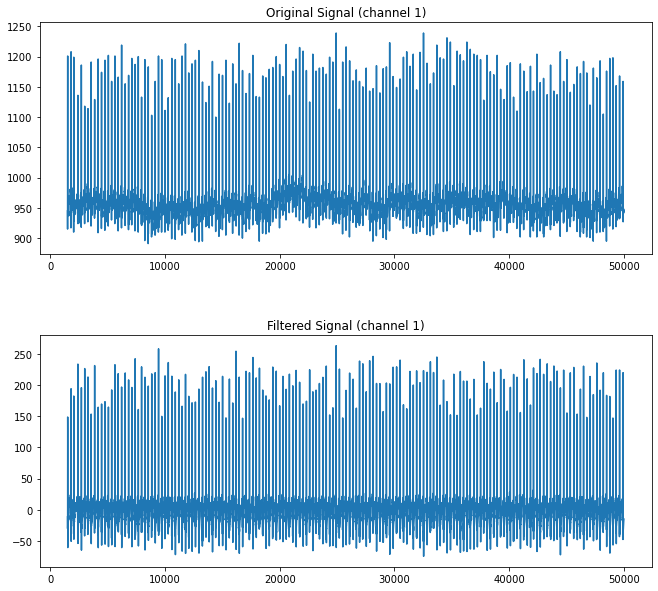

In [5]:
#Plot original and filtered data for channel 1
Rows = np.arange(1500,50000,5)

#Unfiltered signal
Y = DF.iloc[Rows,1]

plt.figure(3,figsize=[10,9])

plt.subplot(212)
plt.plot(Rows, filtered[Rows])
plt.title('Filtered Signal (channel 1)')    

plt.subplot(211)
plt.plot(Rows, Y)
plt.title('Original Signal (channel 1)')    


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

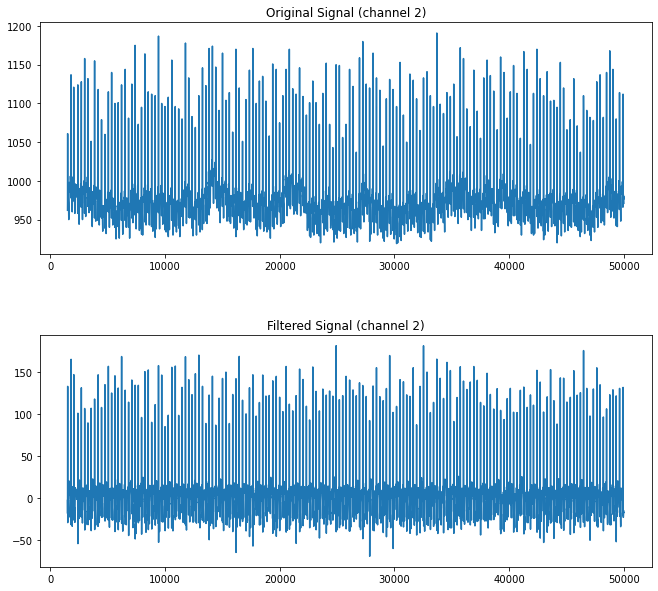

In [6]:
#Plot original and filtered data for channel 2

Rows = np.arange(1500,50000,5)

#Unfiltered signal
Y = DF.iloc[Rows,2]

plt.figure(3,figsize=[10,9])

plt.subplot(212)
plt.plot(Rows, filtered2[Rows])
plt.title('Filtered Signal (channel 2)')    

plt.subplot(211)
plt.plot(Rows, Y)
plt.title('Original Signal (channel 2)')    


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

## Load training data

In [7]:
#function that returns 1 if annotation corresponds to a beat otherwise returns 0
def is_beat(x):
    if (x=='N' or x=='L' or x=='R' or x=='B' or x=='A' or x=='a' or x=='J' or x=='S' or x=='V' or x=='r' or x=='F' or x=='e' or x=='j'
         or x=='n' or x=='E' or x=='/' or x=='f' or x=='Q' or x=='?'):
        return 1
    else:
        return 0
    
#function that returns appropriate dimension index based on beat annotation for one hot encodings 
def beat_to_dimension(x):
    if x=='N':  #N  Normal beat
        return 0
    if x=='L':  #L  Left bundle branch block beat
        return 1
    if x=='R':  #R  Right bundle branch block beat
        return 2
    if x=='B':  #B  Bundle branch block beat (unspecified)
        return 3
    if x=='A':  #A  Atrial premature beat
        return 4 
    if x=='a':  #a  Aberrated atrial premature beat
        return 5
    if x=='J':  #J  Nodal (junctional) premature beat
        return 6
    if x=='S':  #S  Supraventricular premature or ectopic beat (atrial or nodal)
        return 7
    if x=='V':  #V  Premature ventricular contraction
        return 8
    if x=='r':  #r  R-on-T premature ventricular contraction
        return 9
    if x=='F':  #F  Fusion of ventricular and normal beat
        return 10
    if x=='e':  #e  Atrial escape beat
        return 11
    if x=='j':  #j  Nodal (junctional) escape beat
        return 12
    if x=='n':  #n  Supraventricular escape beat (atrial or nodal)
        return 13
    if x=='E':  #E  Ventricular escape beat
        return 14
    if x=='/':  #/  Paced beat
        return 15
    if x=='f':  #f  Fusion of paced and normal beat
        return 16
    if x=='Q':  #Q  Unclassifiable beat
        return 17
    if x=='?':  #?  Beat not classified during learning
        return 18

In [8]:
#Time slot for training/testing: 7.50 minutes (note that the time slot window is different for each patient).

Start_min = 15  # time-window start
End_min = 18  #time-window end
End_test = End_min+3



#Using the fact that there are 360 samples per second
Index_start = int(360*Start_min*60)   # samples/sec * starting time (mins) * 60sec/min
Index_finish = int(360*End_min*60)    # samples/sec * end time (mins) * 60sec/min
Index_test = int(360*End_test*60)

#Training data
#channel 1
x = filtered[Index_start:Index_finish]
#channel 2
x2 = filtered2[Index_start:Index_finish]

#Both channels
trainning_data = np.concatenate((x,x2),axis=0).reshape(2,len(x))
#print(trainning_data.shape,x.shape)


#print(x.shape,x2.shape)

##Test data
Test = filtered[Index_finish:Index_test]
Test2 = filtered2[Index_finish:Index_test]
#Both channels
test_data = np.concatenate((Test,Test2),axis=0).reshape(2,len(Test))
print(test_data.shape,Test.shape)



#one hot encoding for targets (19 different beat types)
ytarget = np.zeros((len(x),19))
ytarget_test =np.zeros((len(x),19))

 

#function that performs one hot encodings for targets    
def one_hot(tau):     
    for i in range(len(DF_annotations["Type"])):   #Loop over annotations
        if (Index_start<DF_annotations.iloc[i]["Sample #"]<Index_finish):  # Annotations inside time-window of interest
            if is_beat(DF_annotations.iloc[i]["Type"]):                     # If annotation is a beat:
                index = beat_to_dimension(DF_annotations.iloc[i]["Type"])     # dimension for one-hot encoding of beat
                index2 = DF_annotations.iloc[i]["Sample #"]-Index_start       # index for time, normalized to start from index 0
                ytarget[index2][index]=1
                for t in range(tau):
                    ytarget[index2+t][index]=1

                
                
    for i in range(len(DF_annotations["Type"])):   #Loop over annotations
        if (Index_finish<DF_annotations.iloc[i]["Sample #"]<Index_test):  # Annotations inside time-window of interest
            if is_beat(DF_annotations.iloc[i]["Type"]):                     # If annotation is a beat:
                index = beat_to_dimension(DF_annotations.iloc[i]["Type"])     # dimension for one-hot encoding of beat
                index2 = DF_annotations.iloc[i]["Sample #"]-Index_finish       # index for time, normalized to start from index 0
                ytarget_test[index2][index]=1
                for t in range(tau):
                    if (index2+t) < len(ytarget_test):
                        ytarget_test[index2+t][index]=1
                        
one_hot(10)

(2, 64800) (64800,)
(2, 64800) (64800,)


In [85]:
ytarget_2class = np.zeros((len(x),2))  #for two class classification: most common beat and other

sum_ytar = np.sum(ytarget,axis=0)
index = np.argmax(sum_ytar)  #index of most common heart beat

for i in range(len(ytarget)):
    if np.amax(ytarget[i,:])!=0:
        beat_index = np.argmax(ytarget[i,:])
        if beat_index==index:
            ytarget_2class[i,0]=1
        else:
            ytarget_2class[i,1]=1



ytarget_2class_test= np.zeros((len(x),2))  #for two class classification: most common beat and other

sum_ytar_test = np.sum(ytarget_test,axis=0)
index = np.argmax(sum_ytar_test)  #index of most common heart beat

for i in range(len(ytarget_test)):
    if np.amax(ytarget_test[i,:])!=0:
        beat_index = np.argmax(ytarget_test[i,:])
        if beat_index==index:
            ytarget_2class_test[i,0]=1
        else:
            ytarget_2class_test[i,1]=1      


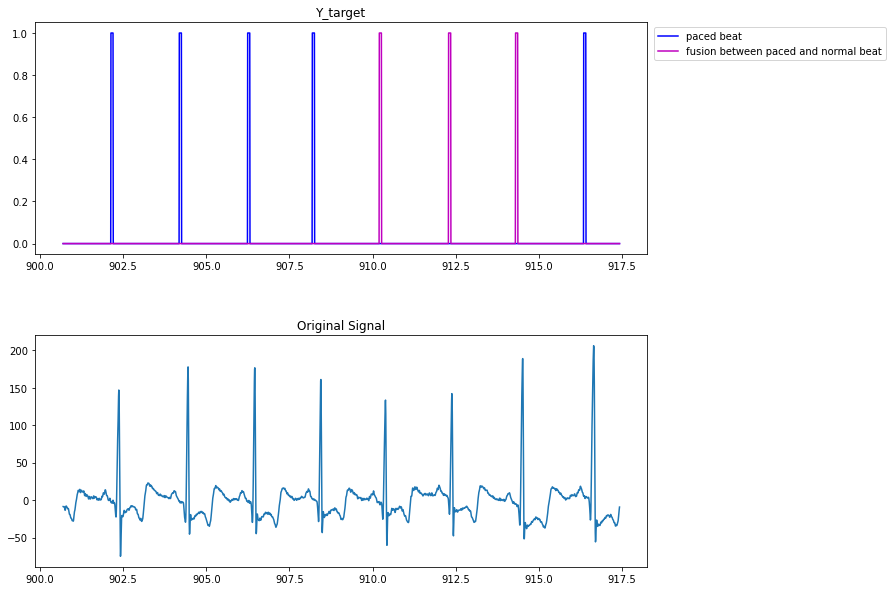

In [10]:
Time = np.arange(15*60, 22.5*60, 7.5*60/len(x)) # x-axis in seconds
TIME = np.arange(100,2510,1)                    # sample points of interest

plt.figure(4,figsize=[10,9])

plt.subplot(212)
plt.plot(Time[TIME], x2[TIME])
plt.title('Original Signal')    

plt.subplot(211)
plt.plot(Time[TIME], ytarget[TIME,15], color='b', label="paced beat")
plt.plot(Time[TIME], ytarget[TIME,16], color='m', label="fusion between paced and normal beat")
plt.title('Y_target')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1))



plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

## ESN

In [102]:
#Code adapted from: https://github.com/cknd/pyESN/blob/master/pyESN.py



def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.
    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s
    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=6, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        
        
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        
        train_MSE = np.sqrt(np.mean((pred_train - outputs)**2))
        
        return (pred_train, train_MSE)

    def predict(self, inputs, targets=None, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))
         
        
        OUTPUTS = self._unscale_teacher(self.out_activation(outputs[1:]))
        predictions = np.zeros((len(OUTPUTS),len(OUTPUTS[0])))
        for i in range(len(OUTPUTS)):
            index = np.argmax(abs(OUTPUTS[i,:]))
            if OUTPUTS[i,index]>0.5:
                predictions[i,index]=1
            #predictions[i,index]=OUTPUTS[i,index]
                    
        if (targets != None).all():
            test_MSE = np.sqrt(np.mean((predictions - targets)**2))
            return predictions, test_MSE, OUTPUTS
        else:
            return predictions, OUTPUTS

## Parameter Tuning

In [211]:
best_mse = 9999999
best_spectral_radius = 0
best_tau = 0
best_n_reservoir = 0
best_input_scaling = 0



spectral_radia = [1.05, 1.1, 1.15]
taus = [10,20,30]
test_n_reservoir = [700, 900, 1000]
test_input_scaling = [None, 0.5]
for spectral_radius in spectral_radia:
    for tau in taus:
        one_hot(tau)
        for n_hidden in test_n_reservoir:
            for scaling in test_input_scaling:
                model = ESN(n_inputs=1, n_outputs=19,n_reservoir=n_hidden, spectral_radius=spectral_radius, input_scaling=scaling)
                TRAIN, train_mse = model.fit(x2,ytarget)
                TEST, test_mse = model.predict(Test2, ytarget_test)
                print("Test MSE={} train MSE={} spectral_radius={} input_Scaling={} n_hidden={} tau={}".format(
                test_mse, train_mse, spectral_radius, scaling, n_hidden, tau))
                if test_mse < best_mse:
                    best_mse = test_mse
                    best_spectral_radius = spectral_radius
                    best_tau = tau
                    best_n_reservoir = n_hidden
                    best_input_scaling = scaling

Test MSE=0.13249002316331884 train MSE=0.015669135883829226 spectral_radius=1.05 input_Scaling=None n_hidden=700 tau=10
Test MSE=0.05515940630539466 train MSE=0.013690296088963516 spectral_radius=1.05 input_Scaling=0.5 n_hidden=700 tau=10
Test MSE=0.0629894738362295 train MSE=0.015313310707099398 spectral_radius=1.05 input_Scaling=None n_hidden=900 tau=10
Test MSE=0.09647372692606287 train MSE=0.013315955627453812 spectral_radius=1.05 input_Scaling=0.5 n_hidden=900 tau=10
Test MSE=0.13120561070587552 train MSE=0.014959185795861767 spectral_radius=1.05 input_Scaling=None n_hidden=1000 tau=10
Test MSE=0.07987970162465509 train MSE=0.012814457846627367 spectral_radius=1.05 input_Scaling=0.5 n_hidden=1000 tau=10
Test MSE=0.060436198697969325 train MSE=0.016743803531299093 spectral_radius=1.05 input_Scaling=None n_hidden=700 tau=20
Test MSE=0.06011279196880311 train MSE=0.014921987910810883 spectral_radius=1.05 input_Scaling=0.5 n_hidden=700 tau=20
Test MSE=0.07063597663784048 train MSE=0.0

In [59]:

best_spectral_radius=1.05
input_Scaling=0.5 
best_n_reservoir=700 
best_tau=10


one_hot(best_tau)
model = ESN(n_inputs=1, n_outputs=19,n_reservoir=best_n_reservoir, spectral_radius=best_spectral_radius, input_scaling=input_Scaling)
TRAIN, train_mse = model.fit(x2,ytarget)
TEST, test_mse, OUTPUTS = model.predict(Test2, ytarget_test)

print("Test MSE={}  Train MSE={}".format(test_mse, train_mse))

Test MSE=0.08822854132067326  Train MSE=0.018727003889643146


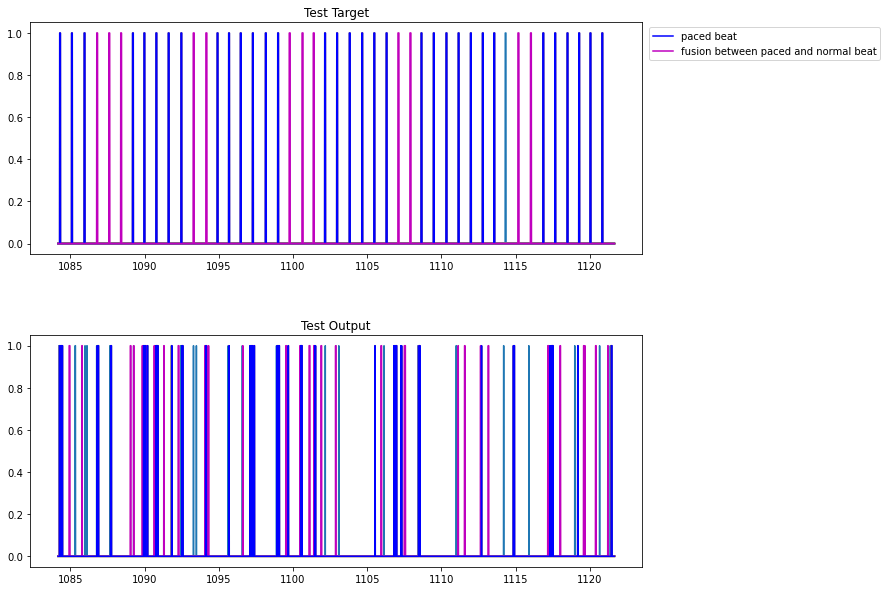

In [66]:
Time = np.arange(Start_min*60, End_min*60, (End_min-Start_min)*60/len(x)) # x-axis in seconds
TIME = np.arange(1500,15000,1)                    # sample points of interest

Test_Time = np.arange(End_min*60, End_test*60, (End_test-End_min)*60/len(TEST))

plt.figure(4,figsize=[10,9])

plt.subplot(212)
plt.plot(Test_Time[TIME], (TEST[TIME]))
plt.plot(Test_Time[TIME], (TEST[TIME,16]), color='m')
plt.plot(Test_Time[TIME], (TEST[TIME,15]), color='b')
plt.title('Test Output')    

plt.subplot(211)
plt.plot(Test_Time[TIME], ytarget_test[TIME])
plt.plot(Test_Time[TIME], ytarget_test[TIME,15], color='b', label="paced beat")
plt.plot(Test_Time[TIME], ytarget_test[TIME,16], color='m', label="fusion between paced and normal beat")
plt.title('Test Target')    

#plt.subplot(211)
#plt.plot(Time[TIME], ytarget[TIME])
#plt.plot(Time[TIME], ytarget[TIME,15], color='b', label="paced beat")
#plt.plot(Time[TIME], ytarget[TIME,16], color='m', label="fusion between paced and normal beat")
#plt.title('Train target')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1))

#plt.subplot(212)
#plt.plot(Time[TIME], TRAIN[TIME])
#plt.plot(Time[TIME], TRAIN[TIME,15], color='b')
#plt.plot(Time[TIME], TRAIN[TIME,16], color='m')
#plt.title('Train output')



plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

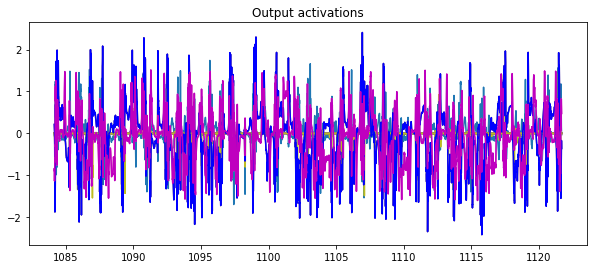

In [69]:
Time = np.arange(Start_min*60, End_min*60, (End_min-Start_min)*60/len(x)) # x-axis in seconds
TIME = np.arange(1500,15000,1)                    # sample points of interest

Test_Time = np.arange(End_min*60, End_test*60, (End_test-End_min)*60/len(TEST))

plt.figure(4,figsize=[10,9])

plt.subplot(212)
plt.plot(Test_Time[TIME],OUTPUTS[TIME])
plt.plot(Test_Time[TIME],OUTPUTS[TIME,15], color='b')
plt.plot(Test_Time[TIME],OUTPUTS[TIME,16], color='m')
plt.title('Output activations')  

plt.show()


In [103]:
## 2 class classificiation

one_hot(best_tau)
model = ESN(n_inputs=1, n_outputs=2, n_reservoir=best_n_reservoir, spectral_radius=best_spectral_radius, sparsity=0.013, noise=0.001, input_shift=None,
                 input_scaling=best_input_scaling, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True)

TRAIN_2class, train_mse = model.fit(x2,ytarget_2class)
TEST_2class, test_Mse, OUTPUTS_2class = model.predict(x2, ytarget_2class_test)
print(train_mse, test_Mse)

0.058887966854342846 0.36831489814767315


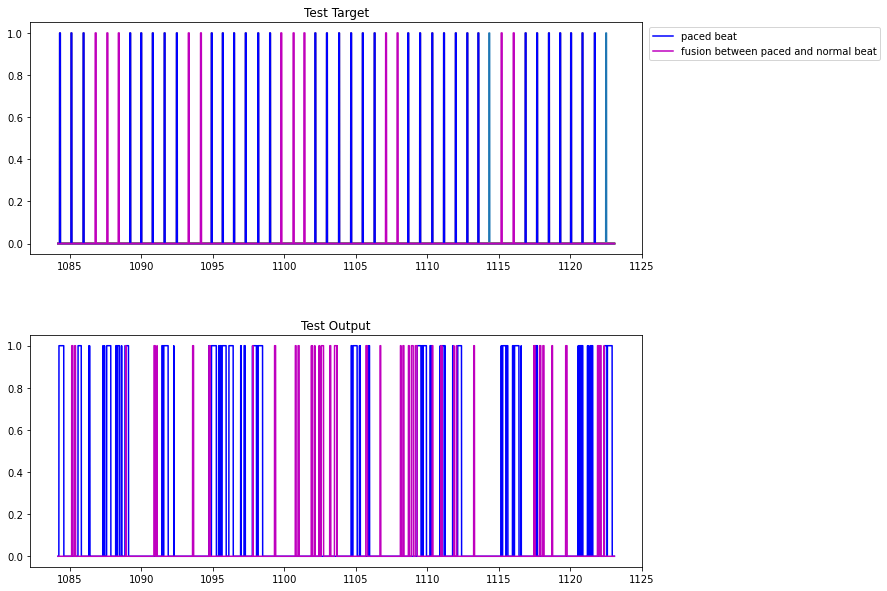

In [109]:
Time = np.arange(Start_min*60, End_min*60, (End_min-Start_min)*60/len(x)) # x-axis in seconds
TIME = np.arange(1500,15510,1)                    # sample points of interest

Test_Time = np.arange(End_min*60, End_test*60, (End_test-End_min)*60/len(TEST))


plt.figure(4,figsize=[10,9])

plt.subplot(212)
#plt.plot(Time[TIME], TEST[TIME])
plt.plot(Test_Time[TIME], TEST_2class[TIME,0], color='b')
plt.plot(Test_Time[TIME], TEST_2class[TIME,1], color='m')
plt.title('Test Output')    

plt.subplot(211)
plt.plot(Test_Time[TIME], ytarget_test[TIME])
plt.plot(Test_Time[TIME], ytarget_test[TIME,15], color='b', label="paced beat")
plt.plot(Test_Time[TIME], ytarget_test[TIME,16], color='m', label="fusion between paced and normal beat")
plt.title('Test Target')    

#plt.subplot(411)
#plt.plot(Time[TIME], ytarget[TIME])
#plt.plot(Time[TIME], ytarget[TIME,15], color='b', label="paced beat")
#plt.plot(Time[TIME], ytarget[TIME,16], color='m', label="fusion between paced and normal beat")
#plt.title('Train target')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1))

#plt.subplot(412)
#plt.plot(Time[TIME], TRAIN_2class[TIME,0], color='b')
#plt.plot(Time[TIME], TRAIN_2class[TIME,1], color='m')
#plt.title('Train')



plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

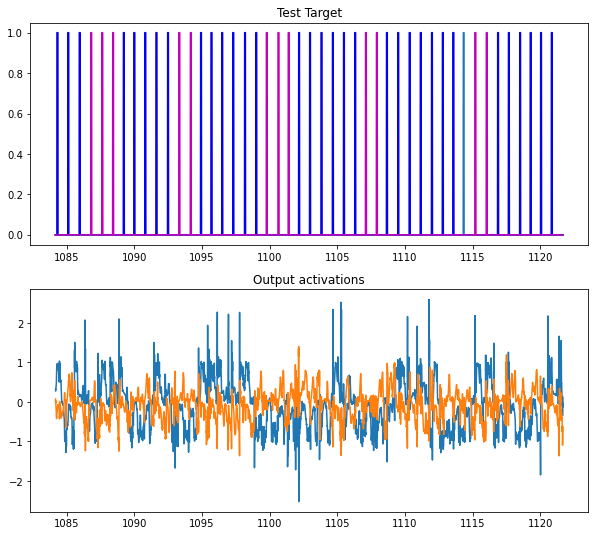

In [105]:
Time = np.arange(Start_min*60, End_min*60, (End_min-Start_min)*60/len(x)) # x-axis in seconds
TIME = np.arange(1500,15000,1)                    # sample points of interest

Test_Time = np.arange(End_min*60, End_test*60, (End_test-End_min)*60/len(TEST))

plt.figure(4,figsize=[10,9])

plt.subplot(212)
plt.plot(Test_Time[TIME],OUTPUTS_2class[TIME])
plt.title('Output activations')  

plt.subplot(211)
plt.plot(Test_Time[TIME], ytarget_test[TIME])
plt.plot(Test_Time[TIME], ytarget_test[TIME,15], color='b')
plt.plot(Test_Time[TIME], ytarget_test[TIME,16], color='m')
plt.title('Test Target')    


plt.show()

##  LESN

In [110]:
## Code was adapted from: https://github.com/reservoirpy/reservoirpy/blob/master/examples/Simple%20Examples%20with%20Mackey-Glass/minimalESN_MackeyGlass.py

"""
A minimalistic Echo State Networks in "plain" scientific Python.
by Mantas LukoÅ¡eviÄ?ius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""

def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    # Set the seed
    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
    try:
        np.random.seed(seed)
    except Exception as e:
        print( "!!! WARNING !!!: Seed was not set correctly.")
        print( "!!! Seed that we tried to use: "+str(seed))
        print( "!!! Error message: "+str(e))
        seed = None
    return seed


def ESNmodel(data, targets, inSize, outSize, resSize, a, spectral_radius, reg, seed, input_scaling, initLen, trainLen, testLen):
    
    # data: array of data
    # targets: array with class labels
    # Seed: Set a particular seed for the random generator
    # initLen: number of time steps during which internal activations are washed-out during training
    # inSize: data dimension
    # outSize: dimension for targets
    # resSize: reservoir size
    # a: leaking rate
    # spectral_radius: spectral radius
    # input scaling: scaling for inputs
    # reg: regularization coefficient, if None, pseudo-inverse is use instead of ridge regression
    
    # initLen: number of time steps for wash out period
    # trainLen: number of time steps during which we train the network
    # testLen: number of time steps during which we test/run the network
        
    set_seed(seed) #random.seed(seed)
    Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
    W = np.random.rand(resSize,resSize)-0.5
    
    #Spectral Radius
    rhoW = max(abs(linalg.eig(W)[0]))
    W *= spectral_radius / rhoW

    # allocated memory for the design (collected states) matrix
    X = np.zeros((1+inSize+resSize,trainLen-initLen))

    # set the corresponding target matrix directly
    Yt = targets[initLen:trainLen]
        
    # run the reservoir with the data and collect X
    x = np.zeros((resSize,1))
    for t in range(trainLen):
        u = data[t]
        # ESN update equation = we compute x(t+1) based on x(t) and input u(t)
        x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
        # if t > washout period
        if t >= initLen:
            X[:,t-initLen] = np.vstack((1,u,x))[:,0]

            
    # train the output
    X_T = X.T
    if reg is not None:
        # use ridge regression (linear regression with regularization)
        Wout = np.dot(np.dot(Yt.T,X_T), linalg.inv(np.dot(X,X_T) + reg*np.eye(1+inSize+resSize) ) )
    else:
        # use pseudo inverse
        Wout = np.dot( Yt.T, linalg.pinv(X) )

    # run the trained ESN in a generative mode. no need to initialize here,
    # because x is initialized with training data and we continue from there.
    Y = np.zeros((outSize,testLen))
    Original = np.zeros((outSize,testLen))
    u = data[trainLen-1]

    
    for t in range(testLen):
        DOT1 = np.dot( Win, np.vstack((1,u)))
        DOT2 = np.dot( W, x )

        x = (1-a)*x + a*np.tanh( DOT1 + DOT2 )
        y = np.dot( Wout, np.vstack((1,u,x)))
        Original[:,t]=y[:,0]
        index = np.argmax(abs(y))
        if (y[index]>=0.15):
            Y[index,t] = 1
        else:
            Y[index,t] = 0
        u = data[t]
    
    
    # compute MSE for the first errorLen time steps
    errorLen = testLen
    mse = np.sqrt(np.mean((Y.T - targets[:testLen])**2))

    
    #returns: mse obtained in testing, binary output signal, original output signal
    return mse, Y.T, Original.T

## Parameter Tuning

In [26]:
initLen = 0
trainLen = 40000
testLen =  10000 

best_mse = 9999999
best_spectral_radius = 0
best_tau = 0
best_n_reservoir = 0
best_input_scaling = 0
best_leakingRate = 0



spectral_radia = [0.9, 1.1]
taus = [10,20]
test_n_reservoir = [500, 750, 1000]
test_input_scaling = [1, 0.5]
leaking_rate = [0.3, 0.9, 1.3]



for spectral_radius in spectral_radia:
    for tau in taus:
        one_hot(tau)
        for n_hidden in test_n_reservoir:
            for scaling in test_input_scaling:
                for lr in leaking_rate:
                    mse, Y, y = ESNmodel(data=filtered2, targets=ytarget, inSize = 1,outSize = 19, resSize = n_hidden, a = lr, spectral_radius = spectral_radius, reg = 1e-6, input_scaling = scaling, seed=42, initLen=initLen, trainLen=trainLen, testLen=testLen)
                    print("Test MSE={} spectral_radius={} input_Scaling={} n_hidden={} tau={} leaking_rate={}".format(
                    mse, spectral_radius, scaling, n_hidden, tau, lr))
                    if mse < best_mse:
                        best_mse = mse
                        best_spectral_radius = spectral_radius
                        best_tau = tau
                        best_n_reservoir = n_hidden
                        best_input_scaling = scaling
                        best_leakingRate = lr

Test MSE=0.04989462580489532 spectral_radius=0.9 input_Scaling=1 n_hidden=500 tau=10 leaking_rate=0.3
Test MSE=0.04478016478190692 spectral_radius=0.9 input_Scaling=1 n_hidden=500 tau=10 leaking_rate=0.9
Test MSE=0.0469041575982343 spectral_radius=0.9 input_Scaling=1 n_hidden=500 tau=10 leaking_rate=1.3
Test MSE=0.05062763963228823 spectral_radius=0.9 input_Scaling=0.5 n_hidden=500 tau=10 leaking_rate=0.3
Test MSE=0.04501461750891242 spectral_radius=0.9 input_Scaling=0.5 n_hidden=500 tau=10 leaking_rate=0.9
Test MSE=0.045247855430424894 spectral_radius=0.9 input_Scaling=0.5 n_hidden=500 tau=10 leaking_rate=1.3
Test MSE=0.05196152422706632 spectral_radius=0.9 input_Scaling=1 n_hidden=750 tau=10 leaking_rate=0.3
Test MSE=0.045131387140915115 spectral_radius=0.9 input_Scaling=1 n_hidden=750 tau=10 leaking_rate=0.9
Test MSE=0.0469041575982343 spectral_radius=0.9 input_Scaling=1 n_hidden=750 tau=10 leaking_rate=1.3
Test MSE=0.05010515258722873 spectral_radius=0.9 input_Scaling=0.5 n_hidden=

In [27]:
print("Test MSE={} spectral_radius={} input_Scaling={} n_hidden={} tau={} leaking_rate={}".format(
                    best_mse, best_spectral_radius, best_input_scaling, best_n_reservoir, best_tau, best_leakingRate))

Test MSE=0.04478016478190692 spectral_radius=0.9 input_Scaling=1 n_hidden=500 tau=10 leaking_rate=0.9


In [111]:
initLen = 0
trainLen = 40000
testLen =  10000 

best_spectral_radius=0.9
best_input_scaling = 1
best_n_reservoir = 500
best_tau = 10
best_leakingRate = 0.9

one_hot(best_tau)

mse, Y, y = ESNmodel(data=filtered2, targets=ytarget, inSize = 1,outSize = 19, resSize = best_n_reservoir, a = best_leakingRate, spectral_radius = best_spectral_radius, reg = 1e-6,
          input_scaling = best_input_scaling, seed=42, initLen=initLen, trainLen=trainLen, testLen=testLen)
print(mse)

0.06836434897317692


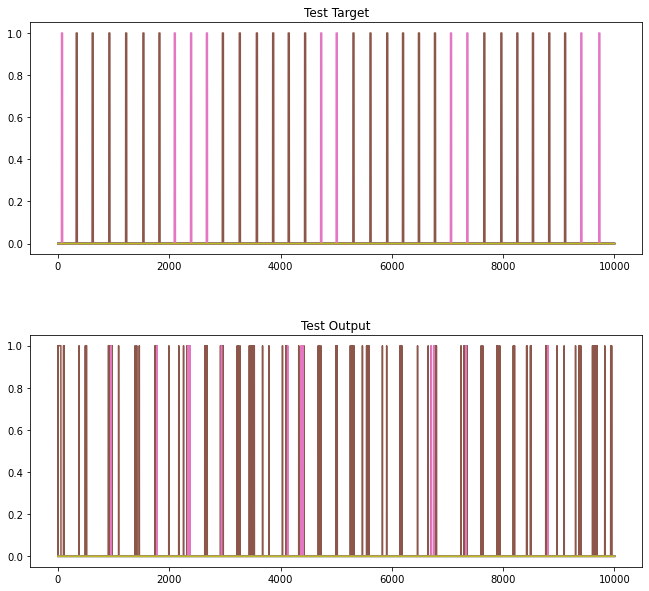

In [139]:
plt.figure(5,figsize=[10,9])

plt.subplot(212)
plt.plot((Y))
#plt.plot(Y[:,16], color='m')
#plt.plot(Y[:,15], color='b')
plt.title('Test Output')    

plt.subplot(211)
plt.plot(ytarget[40000:50000])
#plt.plot(ytarget[trainLen:trainLen+testLen,15], color='b')
#plt.plot(ytarget[trainLen:trainLen+testLen,16], color='m')
plt.title('Test Target')    

#plt.subplot(313)
#plt.plot(y)
#plt.plot(ytarget[trainLen:trainLen+testLen,15], color='b')
#plt.plot(ytarget[trainLen:trainLen+testLen,16], color='m')
#plt.title('Original output')   

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

## Parameter tuning 2 class

In [30]:
initLen = 0
trainLen = 40000
testLen =  10000 

best_mse_2class = 9999999
best_spectral_radius_2class = 0
best_tau_2class = 0
best_n_reservoir_2class = 0
best_input_scaling_2class = 0
best_leakingRate_2class = 0



spectral_radia = [0.9, 1.1]
taus = [10,20]
test_n_reservoir = [500, 750, 1000]
test_input_scaling = [1, 0.5]
leaking_rate = [0.3, 0.9, 1.3]



for spectral_radius in spectral_radia:
    for tau in taus:
        one_hot(tau)
        for n_hidden in test_n_reservoir:
            for scaling in test_input_scaling:
                for lr in leaking_rate:
                    mse, Y, y = ESNmodel(data=filtered2, targets=ytarget_2class, inSize = 1,outSize = 2, resSize = n_hidden, a = lr, spectral_radius = spectral_radius, reg = 1e-6, input_scaling = scaling, seed=42, initLen=initLen, trainLen=trainLen, testLen=testLen)
                    print("Test MSE={} spectral_radius={} input_Scaling={} n_hidden={} tau={} leaking_rate={}".format(
                    mse, spectral_radius, scaling, n_hidden, tau, lr))
                    if mse < best_mse_2class:
                        best_mse_2class = mse
                        best_spectral_radius_2class = spectral_radius
                        best_tau_2class = tau
                        best_n_reservoir_2class = n_hidden
                        best_input_scaling_2class = scaling
                        best_leakingRate_2class = lr



Test MSE=0.08916277250063505 spectral_radius=0.9 input_Scaling=1 n_hidden=500 tau=10 leaking_rate=0.3
Test MSE=0.0806225774829855 spectral_radius=0.9 input_Scaling=1 n_hidden=500 tau=10 leaking_rate=0.9
Test MSE=0.08660254037844387 spectral_radius=0.9 input_Scaling=1 n_hidden=500 tau=10 leaking_rate=1.3
Test MSE=0.0940744386111339 spectral_radius=0.9 input_Scaling=0.5 n_hidden=500 tau=10 leaking_rate=0.3
Test MSE=0.08215838362577492 spectral_radius=0.9 input_Scaling=0.5 n_hidden=500 tau=10 leaking_rate=0.9
Test MSE=0.08544003745317531 spectral_radius=0.9 input_Scaling=0.5 n_hidden=500 tau=10 leaking_rate=1.3
Test MSE=0.09192388155425117 spectral_radius=0.9 input_Scaling=1 n_hidden=750 tau=10 leaking_rate=0.3
Test MSE=0.0818535277187245 spectral_radius=0.9 input_Scaling=1 n_hidden=750 tau=10 leaking_rate=0.9
Test MSE=0.08916277250063505 spectral_radius=0.9 input_Scaling=1 n_hidden=750 tau=10 leaking_rate=1.3
Test MSE=0.09772410142846032 spectral_radius=0.9 input_Scaling=0.5 n_hidden=750

In [140]:
print("Test MSE={} spectral_radius={} input_Scaling={} n_hidden={} tau={} leaking_rate={}".format(
                    best_mse_2class, best_spectral_radius_2class, best_input_scaling_2class, best_n_reservoir_2class, best_tau_2class, best_leakingRate_2class))

Test MSE=0.08 spectral_radius=1.1 input_Scaling=0.5 n_hidden=750 tau=10 leaking_rate=1.3


In [141]:
initLen = 0
trainLen = 40000
testLen =  10000 
mse_2class, Y2class, y2class = ESNmodel(data=filtered2, targets=ytarget_2class, inSize = 1,outSize = 2, resSize = best_n_reservoir_2class, a = best_leakingRate_2class, spectral_radius = best_spectral_radius_2class, reg = 1e-6,
          input_scaling = best_input_scaling_2class, seed=42, initLen=initLen, trainLen=trainLen, testLen=testLen)
print(mse)

0.06836434897317692


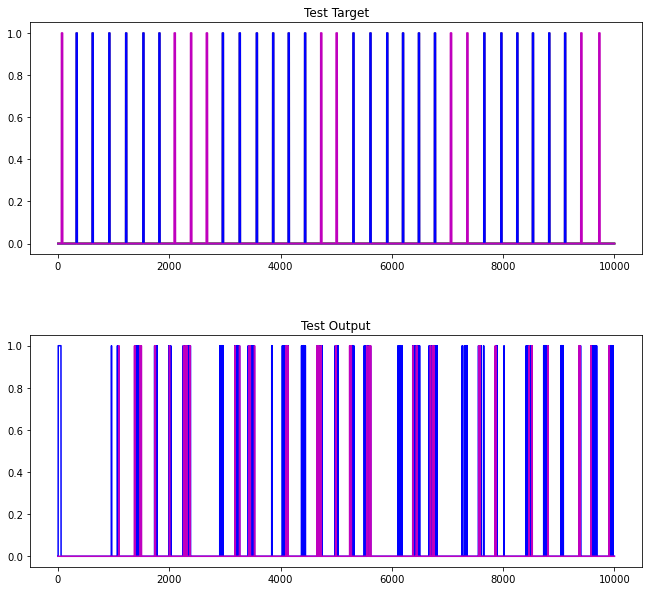

In [150]:
plt.figure(5,figsize=[10,9])

plt.subplot(212)
plt.plot(Y2class[:,0], color='b')
plt.plot(Y2class[:,1], color='m')
plt.title('Test Output')    

plt.subplot(211)
plt.plot(ytarget[40000:50000])
plt.plot(ytarget[trainLen:trainLen+testLen,15], color='b')
plt.plot(ytarget[trainLen:trainLen+testLen,16], color='m')
plt.title('Test Target')    

#plt.subplot(313)
#plt.plot(y2class)
#plt.plot(ytarget[trainLen:trainLen+testLen,15], color='b')
#plt.plot(ytarget[trainLen:trainLen+testLen,16], color='m')
#plt.title('Original output')   

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()